# Tree Networks

In [1]:
# Regular Trees
import networkx as nx
import random

sizes = [50, 100, 150, 200, 250, 300]
degrees = [2, 3, 4, 5]
sample_size = 1000


def generate_random_regular_tree(degree, max_node_count):
    """Generates a random tree with max_node_count nodes where each node as at max degree children"""
    g = nx.Graph()
    g.add_node(0)
    nodes = [(0,0)]
    node_count = 1
    while node_count != max_node_count:
        node_idx = random.randint(0, len(nodes) - 1)
        # Add new node
        g.add_node(node_count)
        nodes.append((node_count, 0))
        # New node becomes child
        g.add_edge(nodes[node_idx][0], node_count)
        nodes[node_idx] = (nodes[node_idx][0], nodes[node_idx][1] + 1)
        # Remove if degree reached
        if nodes[node_idx][1] == degree:
            nodes.pop(node_idx)
        # Increase node count
        node_count += 1
    return g


def test(pair):
    """Generates sample_size random regular trees and tries to predict the root
    returns a tuple
    (degree, node_count, sample_size, correct_prediction_count)"""
    correct_count = 0
    for _ in range(sample_size):
        d, s = pair
        t = generate_random_regular_tree(d, s)
        adj_list = raw.networkx_graph_to_adj_list(t)
        rc_prediction = raw.get_center_prediction(adj_list, use_fact=False)

        correct_prediction = any(map(lambda prediction: prediction == 0, rc_prediction))
        if correct_prediction:
            correct_count += 1
    return (d,s,sample_size,correct_count)  

In [16]:
import rumor_centrality.rumor_detection as raw
from multiprocessing import Pool

pairs = []
for d in degrees:
    for s in sizes:
        pairs.append((d, s))
        
        
with Pool(len(pairs)) as p:
    results = p.map(test, pairs)

NameError: name 'degrees' is not defined

In [5]:
_save_results

[(2, 50, 1000, 52),
 (2, 100, 1000, 29),
 (2, 150, 1000, 17),
 (2, 200, 1000, 8),
 (2, 250, 1000, 16),
 (2, 300, 1000, 9),
 (3, 50, 1000, 203),
 (3, 100, 1000, 208),
 (3, 150, 1000, 189),
 (3, 200, 1000, 195),
 (3, 250, 1000, 195),
 (3, 300, 1000, 193),
 (4, 50, 1000, 299),
 (4, 100, 1000, 264),
 (4, 150, 1000, 269),
 (4, 200, 1000, 254),
 (4, 250, 1000, 262),
 (4, 300, 1000, 264),
 (5, 50, 1000, 313),
 (5, 100, 1000, 300),
 (5, 150, 1000, 303),
 (5, 200, 1000, 286),
 (5, 250, 1000, 305),
 (5, 300, 1000, 293)]

In [21]:
lists = list(map(lambda x: (x[0], x[3] / x[2]), results))

In [28]:
lists

[(2, 0.052),
 (2, 0.029),
 (2, 0.017),
 (2, 0.008),
 (2, 0.016),
 (2, 0.009),
 (3, 0.203),
 (3, 0.208),
 (3, 0.189),
 (3, 0.195),
 (3, 0.195),
 (3, 0.193),
 (4, 0.299),
 (4, 0.264),
 (4, 0.269),
 (4, 0.254),
 (4, 0.262),
 (4, 0.264),
 (5, 0.313),
 (5, 0.3),
 (5, 0.303),
 (5, 0.286),
 (5, 0.305),
 (5, 0.293)]

Text(0.5, 1.0, 'Regular Trees')

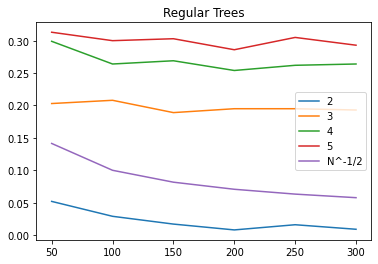

In [38]:
import matplotlib.pyplot as plt

for d in degrees:
    plt.plot(sizes, [l[1] for l in lists if l[0] == d], label=d)
    
plt.plot(sizes, list(map(lambda x: x**-(1/2), sizes)), label="N^-1/2")
plt.legend()
plt.title("Regular Trees")

In [ ]:
# Geometric Trees
# TODO

In [2]:
# General Networks
from tqdm import tqdm

from rumor_centrality.graph_generator import scale_free, small_world
from rumor_centrality.graph_simulations import si
import rumor_centrality.jordan_center_alternative as jo

node_count = 5000
sample_size = 1000

rumor_cent = []
dist_cent = []

for _ in tqdm(range(sample_size)):
    g = scale_free(node_count)
    inf_g, c = si(g, 100, .1, 1)
    adj_list = raw.networkx_graph_to_adj_list(inf_g)
    rc_prediction = raw.get_center_prediction(adj_list, use_fact=False)
    dc_prediction = jo.centers_by_distance_centrality(inf_g)
    rumor_cent.append(nx.shortest_path_length(g, c[0], rc_prediction[0]))
    dist_cent.append(nx.shortest_path_length(g, c[0], dc_prediction[0]))

  0%|                                                                             | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

(array([1., 0., 5., 0., 0., 3., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

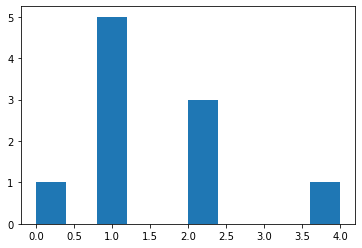

In [53]:
import matplotlib.pyplot as plt

plt.hist(rumor_cent)

(array([1., 0., 4., 0., 0., 4., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

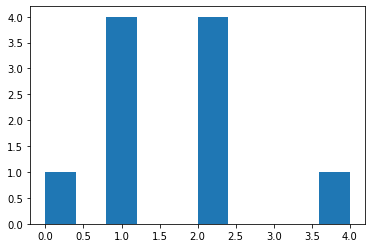

In [54]:
plt.hist(dist_cent)

## Real World Networks

In [28]:
from rumor_centrality.graph_generator import internet, us_power_grid
import networkx as nx

hops = []
for _ in tqdm(range(100)):
    g, c = si(internet(), 10, 0.1, 1)
    print(f"nodes: {len(g.nodes)}")
    adj_list = raw.networkx_graph_to_adj_list(g)
    rc_prediction = raw.get_center_prediction(adj_list, use_fact=False)
    hops.append(nx.shortest_path_length(g, c[0], rc_prediction[0]))

  0%|                                                                              | 0/100 [00:00<?, ?it/s]

nodes: 2991


  1%|▋                                                                     | 1/100 [00:20<33:14, 20.15s/it]

nodes: 728


  4%|██▊                                                                   | 4/100 [00:21<04:53,  3.06s/it]

nodes: 1
nodes: 1


  6%|████▏                                                                 | 6/100 [00:22<02:11,  1.40s/it]

nodes: 129
nodes: 1


  7%|████▉                                                                 | 7/100 [00:22<01:34,  1.02s/it]

nodes: 177


  8%|█████▌                                                                | 8/100 [00:26<03:07,  2.04s/it]

nodes: 1472
nodes: 2811


  9%|██████▎                                                               | 9/100 [00:43<10:26,  6.88s/it]

nodes: 464


 10%|██████▉                                                              | 10/100 [00:44<07:24,  4.94s/it]

nodes: 2904


 11%|███████▌                                                             | 11/100 [01:03<13:34,  9.15s/it]

nodes: 1182


 12%|████████▎                                                            | 12/100 [01:06<10:37,  7.24s/it]

nodes: 500


 14%|█████████▋                                                           | 14/100 [01:06<05:18,  3.71s/it]

nodes: 9
nodes: 1160


 15%|██████████▎                                                          | 15/100 [01:09<04:49,  3.41s/it]

nodes: 2759


 16%|███████████                                                          | 16/100 [01:26<10:35,  7.56s/it]

nodes: 452


 17%|███████████▋                                                         | 17/100 [01:27<07:32,  5.45s/it]

nodes: 2672


 18%|████████████▍                                                        | 18/100 [01:43<11:44,  8.59s/it]

nodes: 901


 19%|█████████████                                                        | 19/100 [01:44<08:47,  6.51s/it]

nodes: 577


 21%|██████████████▍                                                      | 21/100 [01:45<04:29,  3.41s/it]

nodes: 12
nodes: 358


 23%|███████████████▊                                                     | 23/100 [01:46<02:19,  1.81s/it]

nodes: 1
nodes: 2831


 24%|████████████████▌                                                    | 24/100 [02:03<08:04,  6.38s/it]

nodes: 2347


 26%|█████████████████▉                                                   | 26/100 [02:15<06:53,  5.58s/it]

nodes: 9


 27%|██████████████████▋                                                  | 27/100 [02:15<04:49,  3.97s/it]

nodes: 14
nodes: 168


 28%|███████████████████▎                                                 | 28/100 [02:15<03:24,  2.84s/it]

nodes: 1872


 29%|████████████████████                                                 | 29/100 [02:22<04:48,  4.06s/it]

nodes: 2611


 30%|████████████████████▋                                                | 30/100 [02:36<08:21,  7.16s/it]

nodes: 2495


 33%|██████████████████████▊                                              | 33/100 [02:50<05:04,  4.55s/it]

nodes: 1
nodes: 1


 34%|███████████████████████▍                                             | 34/100 [02:51<03:33,  3.24s/it]

nodes: 121
nodes: 3114


 36%|████████████████████████▊                                            | 36/100 [03:13<06:49,  6.39s/it]

nodes: 1
nodes: 2355


 37%|█████████████████████████▌                                           | 37/100 [03:27<08:53,  8.46s/it]

nodes: 2932


 40%|███████████████████████████▌                                         | 40/100 [03:49<06:09,  6.17s/it]

nodes: 90
nodes: 2
nodes: 854


 43%|█████████████████████████████▋                                       | 43/100 [03:51<02:19,  2.45s/it]

nodes: 4
nodes: 2
nodes: 3109


 44%|██████████████████████████████▎                                      | 44/100 [04:14<08:07,  8.71s/it]

nodes: 760


 45%|███████████████████████████████                                      | 45/100 [04:15<05:58,  6.52s/it]

nodes: 3052


 47%|████████████████████████████████▍                                    | 47/100 [04:39<07:10,  8.12s/it]

nodes: 1
nodes: 938


 48%|█████████████████████████████████                                    | 48/100 [04:41<05:25,  6.27s/it]

nodes: 1171


 50%|██████████████████████████████████▌                                  | 50/100 [04:44<03:08,  3.78s/it]

nodes: 1
nodes: 135


 51%|███████████████████████████████████▏                                 | 51/100 [04:44<02:12,  2.71s/it]

nodes: 1323


 53%|████████████████████████████████████▌                                | 53/100 [04:48<01:43,  2.20s/it]

nodes: 25
nodes: 740


 56%|██████████████████████████████████████▋                              | 56/100 [04:50<00:45,  1.02s/it]

nodes: 1
nodes: 1


 58%|████████████████████████████████████████                             | 58/100 [04:50<00:24,  1.69it/s]

nodes: 1
nodes: 1


 60%|█████████████████████████████████████████▍                           | 60/100 [04:50<00:15,  2.63it/s]

nodes: 8
nodes: 63
nodes: 1303


 62%|██████████████████████████████████████████▊                          | 62/100 [04:54<00:37,  1.00it/s]

nodes: 3
nodes: 2338


 65%|████████████████████████████████████████████▊                        | 65/100 [05:06<01:15,  2.15s/it]

nodes: 1
nodes: 37
nodes: 935


 66%|█████████████████████████████████████████████▌                       | 66/100 [05:08<01:09,  2.05s/it]

nodes: 2345


 67%|██████████████████████████████████████████████▏                      | 67/100 [05:20<02:46,  5.04s/it]

nodes: 373


 69%|███████████████████████████████████████████████▌                     | 69/100 [05:21<01:21,  2.62s/it]

nodes: 45
nodes: 250


 70%|████████████████████████████████████████████████▎                    | 70/100 [05:21<00:57,  1.91s/it]

nodes: 469


 71%|████████████████████████████████████████████████▉                    | 71/100 [05:22<00:43,  1.50s/it]

nodes: 2584


 72%|█████████████████████████████████████████████████▋                   | 72/100 [05:37<02:37,  5.63s/it]

nodes: 879


 73%|██████████████████████████████████████████████████▎                  | 73/100 [05:38<01:59,  4.41s/it]

nodes: 1664


 74%|███████████████████████████████████████████████████                  | 74/100 [05:44<02:07,  4.92s/it]

nodes: 2147


 77%|█████████████████████████████████████████████████████▏               | 77/100 [05:55<01:13,  3.21s/it]

nodes: 1
nodes: 2


 78%|█████████████████████████████████████████████████████▊               | 78/100 [05:55<00:50,  2.31s/it]

nodes: 1
nodes: 271


 81%|███████████████████████████████████████████████████████▉             | 81/100 [05:55<00:17,  1.09it/s]

nodes: 2
nodes: 2
nodes: 2443


 82%|████████████████████████████████████████████████████████▌            | 82/100 [06:08<01:17,  4.31s/it]

nodes: 1331


 84%|█████████████████████████████████████████████████████████▉           | 84/100 [06:11<00:46,  2.89s/it]

nodes: 193


 86%|███████████████████████████████████████████████████████████▎         | 86/100 [06:12<00:20,  1.50s/it]

nodes: 1
nodes: 1
nodes: 1265


 87%|████████████████████████████████████████████████████████████         | 87/100 [06:15<00:25,  1.99s/it]

nodes: 1973


 90%|██████████████████████████████████████████████████████████████       | 90/100 [06:23<00:19,  1.95s/it]

nodes: 1
nodes: 1


 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [06:23<00:08,  1.05s/it]

nodes: 73
nodes: 29


 93%|████████████████████████████████████████████████████████████████▏    | 93/100 [06:24<00:05,  1.28it/s]

nodes: 1
nodes: 79


 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [06:24<00:03,  1.64it/s]

nodes: 3139


 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [06:46<00:19,  4.89s/it]

nodes: 1
nodes: 3371


 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [07:12<00:16,  8.03s/it]

nodes: 5


 99%|████████████████████████████████████████████████████████████████████▎| 99/100 [07:13<00:05,  5.69s/it]

nodes: 1
nodes: 1051


100%|████████████████████████████████████████████████████████████████████| 100/100 [07:15<00:00,  4.35s/it]


(array([25.,  0.,  0., 26.,  0.,  0., 34.,  0.,  0., 15.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

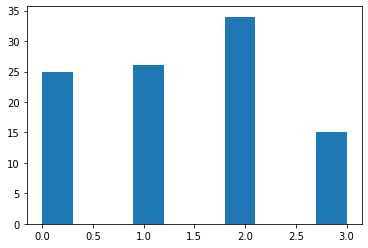

In [30]:
import matplotlib.pyplot as plt

plt.hist(hops)